## 1. Data Preprocessing

#### Load dataset

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from transform import PreProcessing

vnxpress = pd.read_csv('data/vnxpress.csv', encoding='utf-8')
vnxpress

,content,label
0,Tôi thấy nếu đã gửi thông báo mà sàn thương mạ...,0
1,Người VN mình tự đầu độc nhau trên các sàn và ...,2
2,"Có lợi nhuận thì họ kinh doanh thôi, cái quan ...",2
3,"Làm mà không được thì tự chịu, làm mà trôi chả...",2
4,Vấn đề đó không liên quan ở đây bạn ạ. Nếu đã ...,0
...,...,...
6969,"chụp CT thì bth thôi, 2 3 tháng chụp là bth, t...",2
6970,"Không sao đâu chú, liều y tế quy định nên suất...",1
6971,Lương cao lắm,0
6972,Quan trọng là sức khoẻ. Lương cao thì xứng đán...,0


#### Tiền xử lý text

In [4]:
vnxpress['content'] = vnxpress['content'].apply(lambda x: PreProcessing(x).norm())
vnxpress = vnxpress.dropna(subset=['content'])
vnxpress = vnxpress[vnxpress['content'] != ''].drop_duplicates(subset=['content'])
data = vnxpress
data

,content,label
0,gửi thông_báo sàn thương_mại điện_tử bất_kỳ cu...,0
1,việt nam đầu_độc sàn mạng xã_hội lướt vòng hàn...,2
2,lợi_nhuận kinh_doanh quan_trọng vì_sao hàng gi...,2
3,trôi_chảy kiểu đơn_vị hỏi_thăm mệt_mỏi,2
4,vấn_đề liên_quan đấy hàng giả nhái giá rẻ chất...,0
...,...,...
6969,chụp chủ_tịch bình_thường 2 3 chụp bình_thường...,2
6970,liều y_tế quy_định suất liều chụp phép an_tâm ...,1
6971,lương lắm,0
6972,quan_trọng sức_khoẻ lương xứng_đáng rủi_ro côn...,0


label
2    2771
0    2184
1    1856
Name: count, dtype: int64


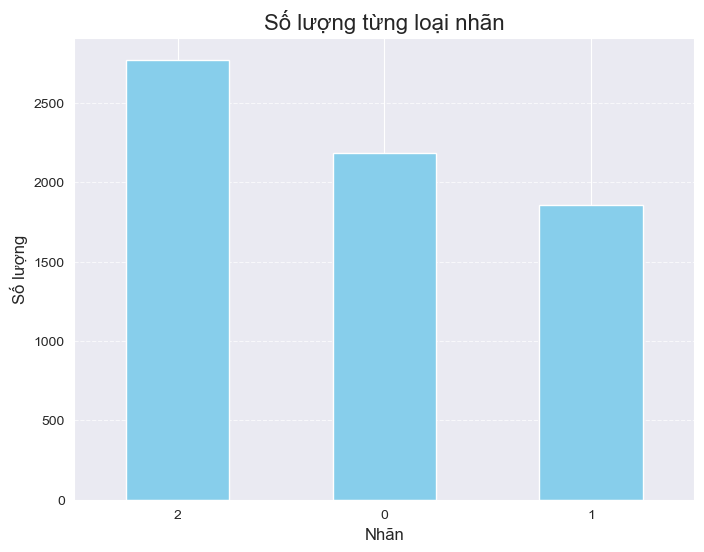

In [5]:
import matplotlib.pyplot as plt

label_counts = data['label'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Số lượng từng loại nhãn', fontsize=16)
plt.xlabel('Nhãn', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Đưa về TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer()
data_tfidf = tfidf_vectorizer.fit_transform(data['content'])

X_train, X_test, y_train, y_test = train_test_split(data_tfidf, data['label'], test_size=0.2, random_state=42)

print(f"TF-IDF matrix shape: {data_tfidf.shape}")
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

TF-IDF matrix shape: (6811, 9616)
Training set size: (5448, 9616)
Testing set size: (1363, 9616)


## 2. Random Forest

#### Grid Search test

In [7]:
from sklearn.model_selection import GridSearchCV

def perform_grid_search(X, y, param_grid, cv_splits=5):
    rf = RandomForestClassifier(random_state=42)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X, y)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy']
}

best_model = perform_grid_search(X_train, y_train, param_grid)

KeyboardInterrupt: 

#### Hàm plot_scores

In [11]:
from tqdm import tqdm
%matplotlib inline

def plot_scores(title, xlabel, x_values, score_mean, score_std, ylabel='Accuracy'):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.errorbar(x_values, score_mean, yerr=score_std, fmt='o-', capsize=5)
    plt.xticks(x_values)
    plt.show()

#### Thay đổi n_estimators, criterion = gini

100%|██████████| 4/4 [06:52<00:00, 103.08s/it]


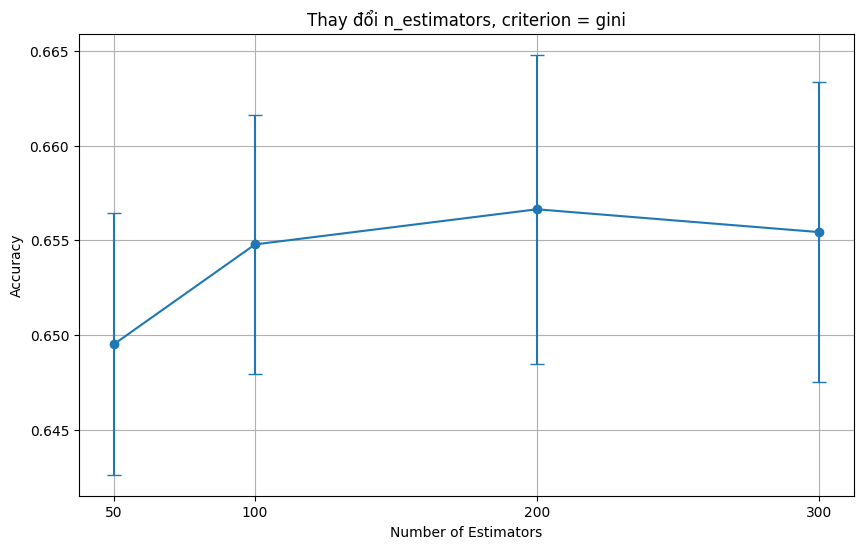

In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

n_estimators = [50, 100, 200, 400]
criterion = 'gini'
score_mean = []
score_std = []

for n_est in tqdm(n_estimators):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = RandomForestClassifier(n_estimators=n_est, criterion=criterion, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi n_estimators, criterion = gini', 'Number of Estimators', n_estimators, score_mean, score_std)

#### Thay đổi criterion, n_estimators = 200

100%|██████████| 2/2 [03:36<00:00, 108.08s/it]


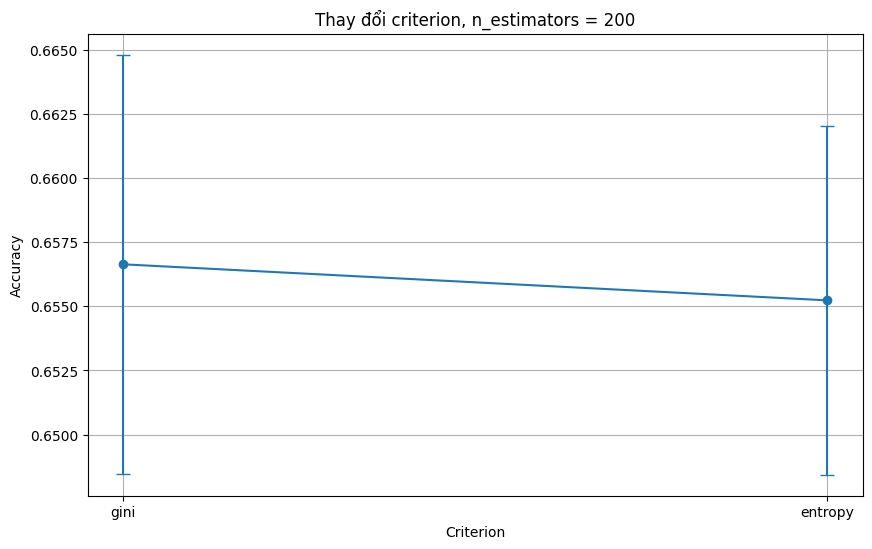

In [13]:
n_estimators = 200
criterion = ['gini', 'entropy']
score_mean = []
score_std = []

for crit in tqdm(criterion):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=crit, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi criterion, n_estimators = 200', 'Criterion', criterion, score_mean, score_std)

## 3. SVM

#### Grid search test

In [14]:
from sklearn.svm import SVC

def perform_grid_search_svm(X, y, param_grid, cv_splits=5):
    svm = SVC(random_state=42)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X, y)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_

# Example usage
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

best_svm_model = perform_grid_search_svm(X_train, y_train, svm_param_grid)

Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Score: 0.6717325289135528


#### Thay đổi kernel, C=1

100%|██████████| 4/4 [03:22<00:00, 50.71s/it]


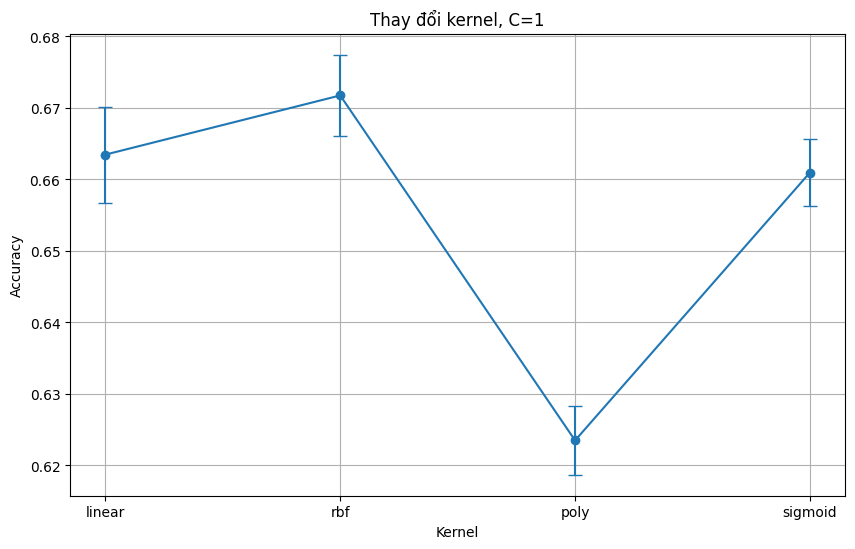

In [15]:
from sklearn.svm import SVC

kernel = ['linear', 'rbf', 'poly', 'sigmoid']
C = 1
score_mean = []
score_std = []

for k in tqdm(kernel):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = SVC(C=C, kernel=k, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi kernel, C=1', 'Kernel', kernel, score_mean, score_std)

#### Thay đổi C, kernel = rbf

100%|██████████| 6/6 [08:59<00:00, 89.91s/it] 


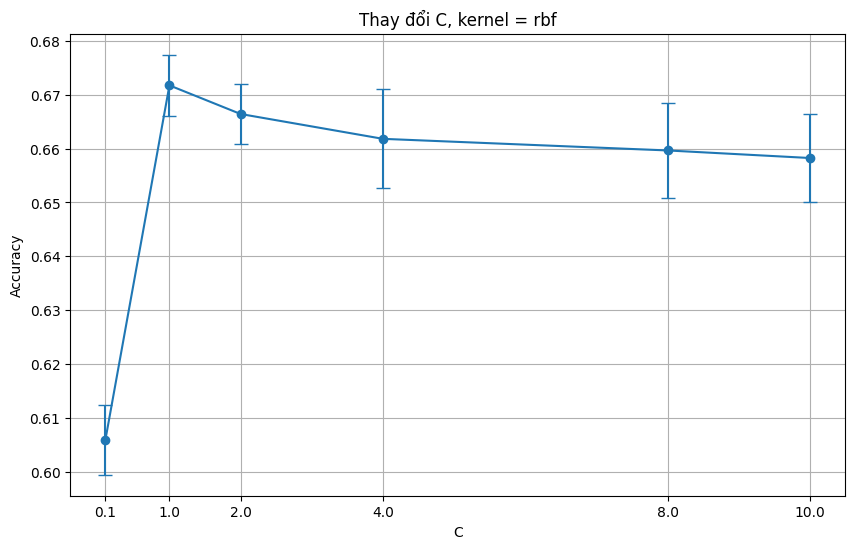

In [16]:
C = [0.1, 1, 2, 4, 8, 10]
kernel = 'rbf'
score_mean = []
score_std = []

for c in tqdm(C):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = SVC(C=c, kernel=kernel, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi C, kernel = rbf', 'C', C, score_mean, score_std)

## 4. So sánh 2 mô hình

In [17]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini')
svm = SVC(C=1, kernel='rbf')

In [18]:
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(C=1)

#### Classification report

In [19]:
from sklearn.metrics import classification_report

rf_predictions = rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.25      0.33      1257
           1       0.76      0.78      0.77      1913
           2       0.62      0.81      0.70      1815

    accuracy                           0.66      4985
   macro avg       0.62      0.61      0.60      4985
weighted avg       0.64      0.66      0.63      4985



In [20]:
svm_predictions = svm.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.35      0.40      1257
           1       0.80      0.77      0.79      1913
           2       0.65      0.79      0.71      1815

    accuracy                           0.67      4985
   macro avg       0.64      0.64      0.63      4985
weighted avg       0.66      0.67      0.66      4985



#### Comparison



Overall Result:
      model_type  avg_accuracy  avg_precision  avg_recall    avg_f1
0            svm      0.669809       0.660917    0.669809  0.660509
1  random_forest      0.655968       0.638694    0.655968  0.633152


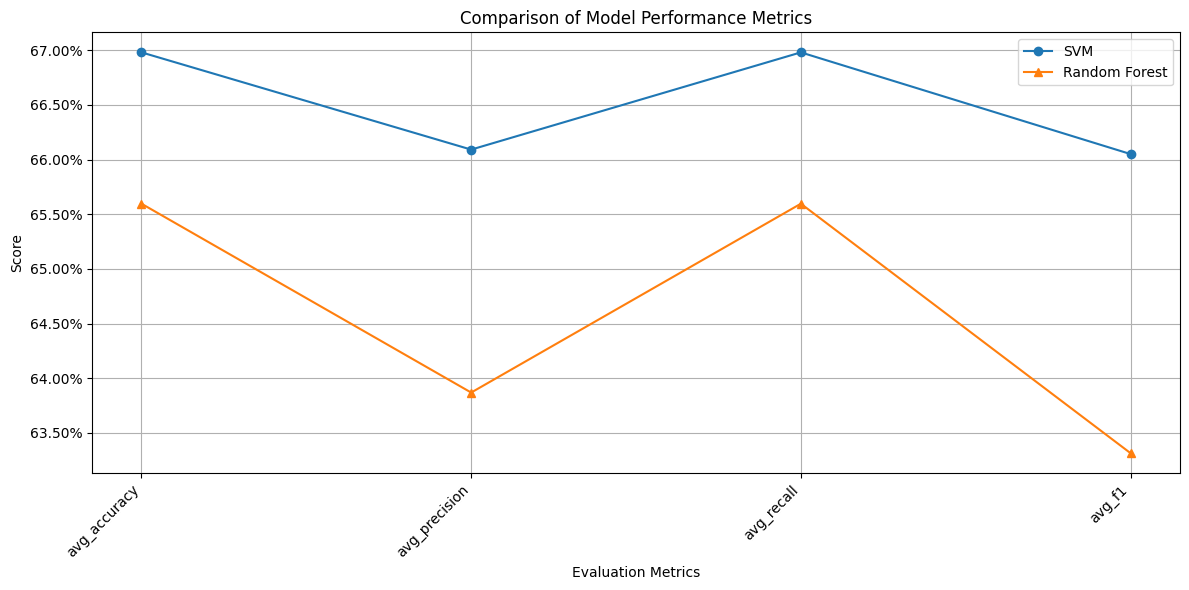

In [21]:
svm_result = {
    'model_type': 'svm',
    'avg_accuracy': classification_report(y_test, svm_predictions, output_dict=True)['accuracy'],
    'avg_precision': classification_report(y_test, svm_predictions, output_dict=True)['weighted avg']['precision'],
    'avg_recall': classification_report(y_test, svm_predictions, output_dict=True)['weighted avg']['recall'],
    'avg_f1': classification_report(y_test, svm_predictions, output_dict=True)['weighted avg']['f1-score']
}

rf_result = {
    'model_type': 'random_forest',
    'avg_accuracy': classification_report(y_test, rf_predictions, output_dict=True)['accuracy'],
    'avg_precision': classification_report(y_test, rf_predictions, output_dict=True)['weighted avg']['precision'],
    'avg_recall': classification_report(y_test, rf_predictions, output_dict=True)['weighted avg']['recall'],
    'avg_f1': classification_report(y_test, rf_predictions, output_dict=True)['weighted avg']['f1-score']
}

results_df = pd.DataFrame([svm_result, rf_result])

print("\n\nOverall Result:")
print(results_df)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

def plot_results(results_df):
    metrics = ['avg_accuracy', 'avg_precision', 'avg_recall', 'avg_f1']
    model_types = results_df['model_type'].values
    x_ticks = np.arange(len(metrics))
    plt.figure(figsize=(12, 6))

    plt.plot(x_ticks, results_df.loc[results_df['model_type'] == 'svm', metrics].values[0], label='SVM', marker='o')

    plt.plot(x_ticks, results_df.loc[results_df['model_type'] == 'random_forest', metrics].values[0], label='Random Forest', marker='^')

    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Score')
    plt.title('Comparison of Model Performance Metrics')
    plt.xticks(x_ticks, metrics, rotation=45, ha='right')
    plt.legend()
    plt.grid(True)

    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.tight_layout()
    plt.show()

plot_results(results_df)

#### Confusion matrix

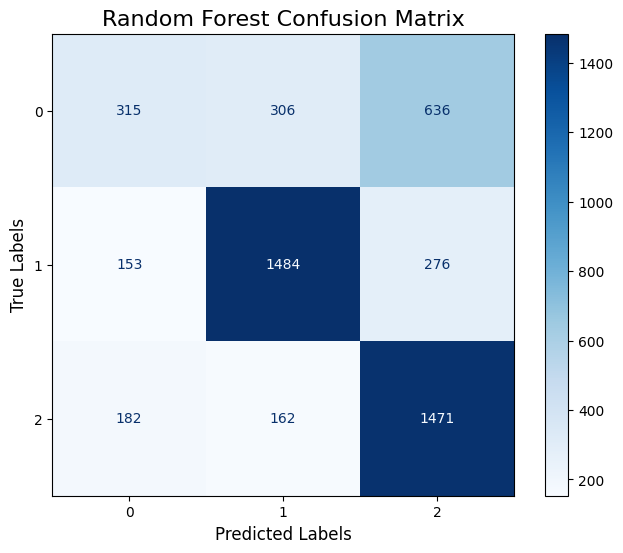

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Random Forest Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_predictions)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf.classes_)
fig_rf, ax_rf = plt.subplots(figsize=(8, 6))
disp_rf.plot(cmap='Blues', ax=ax_rf, colorbar=True)
plt.title("Random Forest Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()


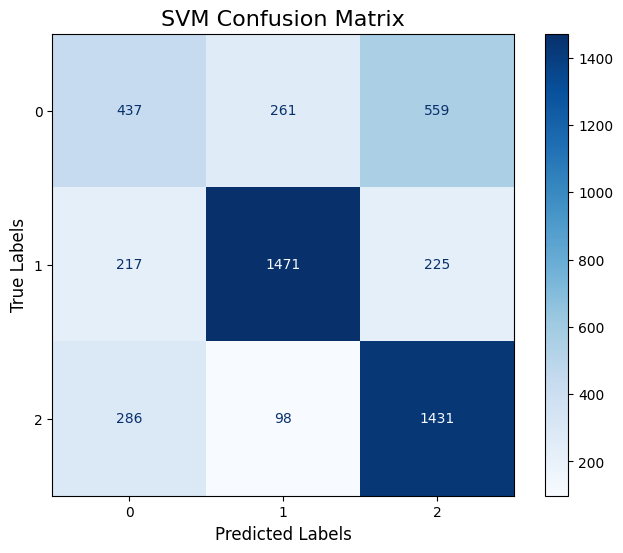

In [23]:
# SVM Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_predictions)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=svm.classes_)
fig_svm, ax_svm = plt.subplots(figsize=(8, 6))
disp_svm.plot(cmap='Blues', ax=ax_svm, colorbar=True)
plt.title("SVM Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()